# Simulating and fitting data using Ball & Stick model

As in the previous tutorial we first create an acquisition scheme that we will use to simulate and fit data.

In [1]:
# load the necessary modules
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
from dmipy.data import saved_acquisition_schemes
import numpy as np

acq_scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

To make our first multi-compartment model, we instantiate the models we want to include:

In [2]:
stick = cylinder_models.C1Stick()
ball = gaussian_models.G1Ball()

Next, we combine them into one model using MultiCompartmentModel.  
Our new model will now be $E = vf_0 * E_{Ball} + vf_1 * E_{Stick}$ where $vf_0$ and $vf_1$ are volume fractions and add up to one.

In [3]:
ball_and_stick = MultiCompartmentModel(models=[ball, stick])

The MultiCompartmentModel automatically joins the parameters and other properties of the models that are given as input.

We can again figure out the required parameter names using parameter_cardinality. As you can see, the parameter names now have the corresponding model prepended to it.

In [4]:
ball_and_stick.parameter_cardinality

OrderedDict([('G1Ball_1_lambda_iso', 1),
             ('C1Stick_1_mu', 2),
             ('C1Stick_1_lambda_par', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

Notice that the graph representation now also includes two models leading to the MC-model:

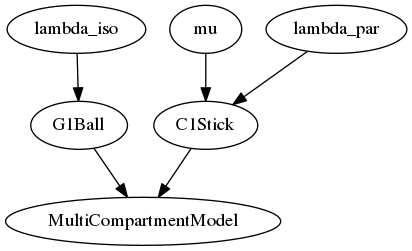

In [5]:
from IPython.display import Image
ball_and_stick.visualize_model_setup(view=False, cleanup=False, with_parameters=True)
Image('Model Setup.png')

It can be seen that now 'partial_volume_0' and 'partial_volume_1' also appear. Note that the ordering in which you give models matters for the significance of the number of the partial_volume! The procedure to simulate data with some random values is the same as before:

In [6]:
mu = (np.pi / 2., np.pi / 2.)
lambda_par = 1.7e-9
lambda_iso = 3e-9
partial_volume = 0.5  # we just give the same volume fraction for both fractions

parameter_vector = ball_and_stick.parameters_to_parameter_vector(
    C1Stick_1_lambda_par=lambda_par,
    G1Ball_1_lambda_iso=lambda_iso,
    C1Stick_1_mu=mu,
    partial_volume_0=partial_volume,
    partial_volume_1=partial_volume
)

E = ball_and_stick.simulate_signal(acq_scheme, parameter_vector)

Fitting the data is also the same as before:

In [7]:
fitted_ball_and_stick = ball_and_stick.fit(acq_scheme, E)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.38118481636 seconds
Fitting of 1 voxels complete in 0.273292064667 seconds.
Average of 0.273292064667 seconds per voxel.


In [8]:
# the optimized results
fitted_ball_and_stick.fitted_parameters

{'C1Stick_1_lambda_par': array([1.70004007e-09]),
 'C1Stick_1_mu': array([[ 1.57079729, -1.57078812]]),
 'G1Ball_1_lambda_iso': array([3.e-09]),
 'partial_volume_0': array([0.49999748]),
 'partial_volume_1': array([0.50000252])}

In [9]:
# and the ground truth correspond
ball_and_stick.parameter_vector_to_parameters(parameter_vector)

{'C1Stick_1_lambda_par': 1.7e-09,
 'C1Stick_1_mu': array([1.57079633, 1.57079633]),
 'G1Ball_1_lambda_iso': 3e-09,
 'partial_volume_0': 0.5,
 'partial_volume_1': 0.5}